In this notebook, we're going to explore the relationship between enterotype taxa in the American Gut fecal samples similar to what was done in Falony et al. 2016 Science.

In [20]:
%matplotlib inline
import skbio
import biom
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib import cm

sns.set_style()

First, we're going to load up the unweighted UniFrac distance matrix for the manuscript package, and compute principal coordinates.

In [33]:
# ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/distance/unweighted.txt.gz
dm_dat = skbio.DistanceMatrix.read('unweighted.txt.gz')
pc_dat = skbio.stats.ordination.pcoa(dm_dat)

# first and second axes
x = pc_dat.samples[0]
y = pc_dat.samples[1]

# form labels, and represent the proportion as a percentage
xlabel = 'PCoA 1 (%0.2f%%)' % (100 * pc_dat.proportion_explained[0])
ylabel = 'PCoA 2 (%0.2f%%)' % (100 * pc_dat.proportion_explained[1])

Next, we're going to load the BIOM table, sort it relative to the sample order in the ordination, convert it to relative abundances and summarize the by both the family and genus levels.

In [34]:
# ftp://ftp.microbio.me/AmericanGut/manuscript-package/1250/deblur_125nt_no_blooms.biom
table = biom.load_table('deblur_125nt_no_blooms.biom')
table = table.sort_order(pc_dat.samples.index)
table.norm()

# define a method for summarizing taxonomy
def collapser(level):
    def f(i, m):
        try:
            return m['taxonomy'][level]
        except:
            return 'Other'
    return f

# summarize for both genus and family
family = table.collapse(collapser(4), collapse_f=lambda tab, axis: tab.sum(axis), 
                        norm=False, axis='observation')
genus = table.collapse(collapser(5), collapse_f=lambda tab, axis: tab.sum(axis),
                       norm=False, axis='observation')

# sanity
assert (family.ids() == pc_dat.samples.index).all()
assert (genus.ids() == pc_dat.samples.index).all()

Now we can pull out vectors representing the relative abundances of the taxa of interest per sample.

In [35]:
# fetch the vectors of interest
rumino = family.data('f__Ruminococcaceae', dense=True, axis='observation')
prevo = genus.data('g__Prevotella', dense=True, axis='observation')
bact = genus.data('g__Bacteroides', dense=True, axis='observation')

And generate a multipanel figure of it all.

/Users/mcdonadt/miniconda3/envs/qiime2-2017.2/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: The required storage space exceeds the available storage space.
Probable causes: nxest or nyest too small or s is too small. (fp>s)
	kx,ky=3,3 nx,ny=12,12 m=196 fp=22971.582032 s=1000.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


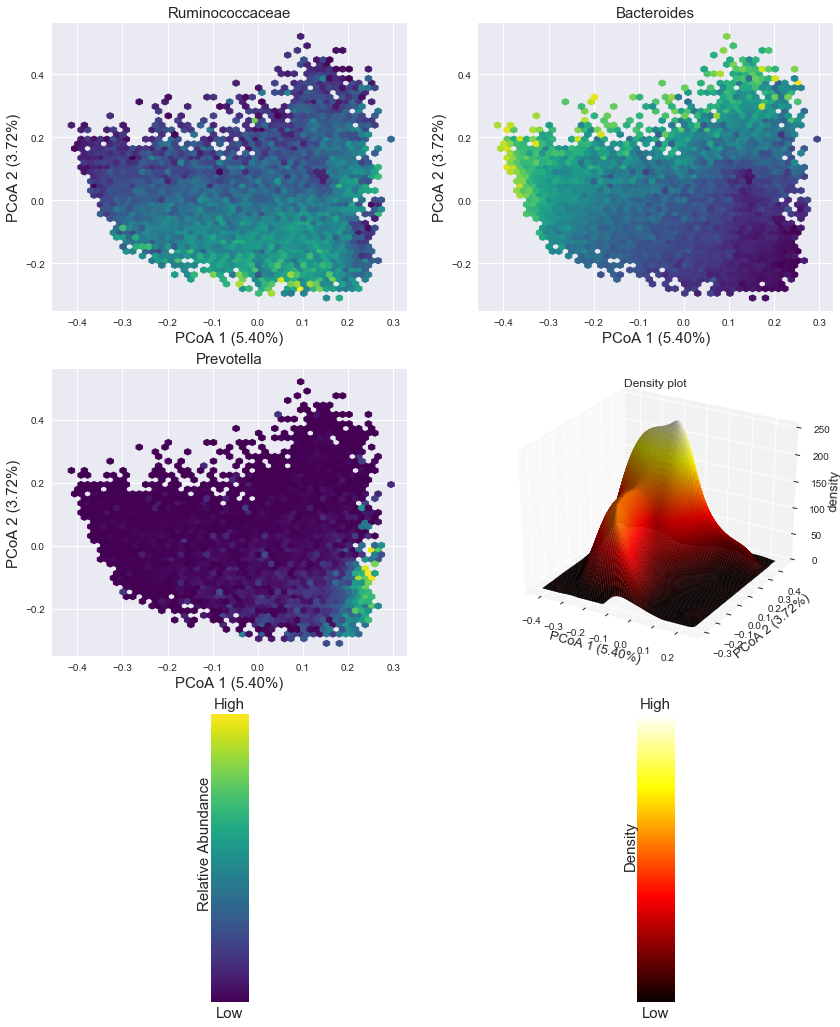

In [36]:
import numpy as np
fontsize = 15

x = pc_dat.samples[0]
y = pc_dat.samples[1]

fig = plt.figure(figsize=(14,18))
ax = fig.add_subplot(3, 2, 1)
ax.hexbin(x, y, gridsize=50, C=rumino, cmap='viridis')
ax.set_title('Ruminococcaceae', fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)

ax = fig.add_subplot(3, 2, 2)
ax.hexbin(x, y, gridsize=50, C=bact, cmap='viridis')
ax.set_title('Bacteroides', fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)

ax = fig.add_subplot(3, 2, 3)
ax.hexbin(x, y, gridsize=50, C=prevo, cmap='viridis')
ax.set_title('Prevotella', fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
ax.set_xlabel(xlabel, fontsize=fontsize)

x = pc_dat.samples[0]
y = pc_dat.samples[1]
hist, xedges, yedges = np.histogram2d(x, y, bins=14) 

xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
xpos = xpos
ypos = ypos
zpos = hist

xnew, ynew = np.mgrid[np.min(xpos):np.max(xpos):80j, np.min(ypos):np.max(ypos):80j]
tck = interpolate.bisplrep(xpos, ypos, zpos, s=1000)
znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

colors = cm.hot(znew / znew.max())

ax = fig.add_subplot(3, 2, 4, projection='3d')
ax.plot_surface(xnew, ynew, znew.clip(0), rstride=1, cstride=1, 
                facecolors=colors, 
                antialiased=True)

ax.set_xlabel(xlabel, fontsize=13)
ax.set_ylabel(ylabel, fontsize=13)
ax.set_zlabel('density', fontsize=13)
ax.set_title('Density plot')
ax.set_facecolor('white')
plt.autoscale(enable=True, axis='both', tight=True)

ax = fig.add_subplot(3, 2, 5)
ax.grid(False)
gradient = np.linspace(0, 1, 256)[::-1]
gradient = np.vstack((gradient, gradient)).T

ax.imshow(gradient, aspect='auto', cmap='viridis')
ax.set_xlim((-9, 10))
ax.set_xlabel('Low', fontsize=15)
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_facecolor('white')
ax.set_title('High', fontsize=15)
ax.text(-1.2, 64, 'Relative Abundance', fontsize=15, rotation=90)

ax = fig.add_subplot(3, 2, 6)
ax.grid(False)
gradient = np.linspace(0, 1, 256)[::-1]
gradient = np.vstack((gradient, gradient)).T

ax.imshow(gradient, aspect='auto', cmap='hot')
ax.set_xlim((-9, 10))
ax.set_xlabel('Low', fontsize=15)
ax.set_xticks([], [])
ax.set_yticks([], [])
ax.set_facecolor('white')
ax.set_title('High', fontsize=15)
ax.text(-1.2, 104, 'Density', fontsize=15, rotation=90)

fig.savefig('ag_enterotypes_unweighted.png')